# Проект: Анализ оттока клиентов сети фитнес-центров «Культурист-датасаентист» с целью удержания посетителей.

## Описание проекта.

Цель — провести анализ оттока клиентов и подготовить план действий по их удержанию.

Задачи:
    - научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
    - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    - проанализировать основные признаки, наиболее сильно влияющие на отток;
    - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами (выделить целевые группы клиентов, предложить меры по снижению оттока, определить другие особенности взаимодействия с клиентами).
    
Источник информации: предоставленная заказчиком csv-таблица, содержащая данные клиентов за предыдущий до проверки факта оттока месяц и информацию на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента.

Структура проекта:
1. [Изучение данных.](#start)
2. [Исследовательский анализ данных.](#eda)
3. [Создание модели прогнозирования оттока клиентов.](#model_creation)
4. [Кластеризация клиентов.](#clusters)
5. [Выводы и рекомендации.](#outcome)

## Изучение данных.<a id="start"></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:/datasets/gym_churn.csv')

In [3]:
display(data.head())
display(data.shape)
data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


(4000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
#приведём названия столбцов к общему виду.
data.columns = data.columns.str.lower()

## Исследовательский анализ данных.<a id="eda"></a>

In [5]:
# Проверяем датасет на пропуски.
display(data.isna().sum())

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Пропусков в данных нет.

In [6]:
#изучаем средние значения признаков и стандартные отклонения
display(data[['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']].describe().round(2))

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,4.68,29.18,146.94,4.32,3.72,1.88,1.77
std,4.55,3.26,96.36,4.19,3.75,0.97,1.05
min,1.00,18.00,0.15,1.00,0.00,0.00,0.00
25%,1.00,27.00,68.87,1.00,1.00,1.18,0.96
50%,1.00,29.00,136.22,1.00,3.00,1.83,1.72
75%,6.00,31.00,210.95,6.00,5.00,2.54,2.51
max,12.00,41.00,552.59,12.00,31.00,6.02,6.15


Возраст основной массы посетителей от 19.4 до 39 лет. Следовательно, более молодые (до 18 лет) и более взрослые (до 41 года) составляют выброс. Средний возраст - 29.18 лет.

Доход от дополнительных услуг в среднем составляет 146.94 рубля. При этом доходы от оказания дополнительных услуг основной массе посетителей колеблются от 0 до 427.02 рублей. Максимальное значение этого показателя составляет 552.59 рублей и доходы больше 427.02 рубля составляют выброс.

До конца текущего абонемента в среднем 4.32 мес. Здесь выбросов нет.

Средняя продолжительность посещения фитнес-центра на момент исследования (лайфтайм) равна 3.72 мес. Основная масса посетителей посещает фитнес центр от 0 до 15 мес., от 15 до 41 мес. - выброс. Следовательно, основная масса клиентов занимается в фитнесс-клубе немногим более года. Люди, занимающиеся фитнесом здесь составляют незначительное меньшинство. Максимальное значение лайфтайма может означать, что практически никто не занимается фитнесом более двух с половиной лет или фитнес-центр открылся около двух с половиной лет назад, или посетители фитнес-центра со временем меняют место занятий.

Средняя частота посещений в неделю за всё время тренировок равна 1.88. Большинство клиентов приходит заниматься от 0 до 4-5 раз в неделю (4.79). В редких случая (это - выброс) люди приходят по шесть и даже семь раз в неделю (6.02), можно предположить, что это - "начинающие новую жизнь", на долго их не хватит, и удержать их не удастся.

Средняя частота посещений в неделю за последний месяц составила 1.77, то есть, она не сильно отличается от предыдущего показателя. Основная масса посетителей в течение последнегог месяца посещала фитнес-центр от 0 до 4-5 дней (4.92). Как и в предыдущем случае в выброс попадают люди, посещавшие фитнес-клуб по 6-7 дней в неделю (6.15).
Два последних показателя измеряют сходные характеристики и имеют близкие значения. Можно говорить, что они дублируют друг-друга. Есть основания полагать, что два этих признака покажут высокую степень взаимной крреляции.

In [7]:
# Изучаем средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.
data_churn_and_retention = data.groupby('churn').mean().round(2)
display(data_churn_and_retention)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Сравнение средних значений признаков для "оттёкших" и удержанных посетителей показывает довольно серьёзные различия членов этих групп.

Удержанные чаще живут/работают около фитнес-центра, хотя разница здесь не велика.

Удержанные имеют в полтора раза более высокую долю посещений по партнёрской программе. То есть, есть заметная зависимость между стоимостью занятий и удержанием/оттоком клиентов.

Средняя продолжительность абонемента удержанных в 3.32 раза выше, чем у "оттёкших".

"Оттёкшие" ходят на групповые занятия в 1.7 раза реже. Что логично, при прочих равных в коллективе заниматься интереснее, плюс взаимный положительный пример.

Средний возраст удержанных клиентов (почти 30 лет) на три года выше, чем "оттёкших" (почти 27 лет). Можно предположить, что, чем посетители старше, тем серьёзнее они относятся к своему здоровью и/или испытывают бОльшую потребность в движении (выше должность - "сидячая" работа), и/или у них бОльшие финансовые возможности, позволяющие им тратить деньги на фитнес и сопутствующие услуги.

Удержанные в среднем тратят в 1.38 раза больше средств на получение в фитнес-центре сопутствующих (дополнительных) услуг, что косвенно подтверждает предыдущее предположение.

Удержанным клиентам свойственно бОльшее время до конца текущего абонемента 5.28 против 1.66 мес., т.е. - в 3.18 раза, что весьма ощутимо.

Так же велика разница в среднем лайфтайме: в 4.76 раза (4.71 против 0.99 мес.).

Средняя частота посещений в неделю за всё время для удержанных выше, чем для "оттёкших" в 1.37 раза.

Тот же показатель за последний месяц отличается в пользу удержанных в 1.95 раза. Два последних показателя свидетельствуют, что удержанные посещают занятия чаще. При чём, в последний месяц этот показатель увеличился, главным образом за счёт того, что "оттекающие" стали ходить заметно реже.

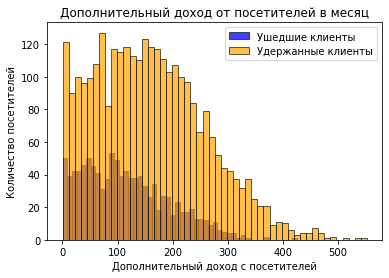

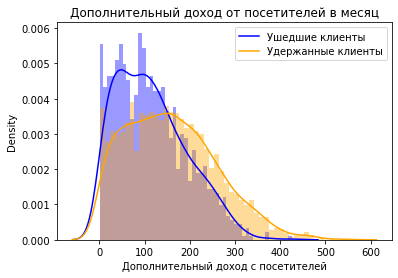

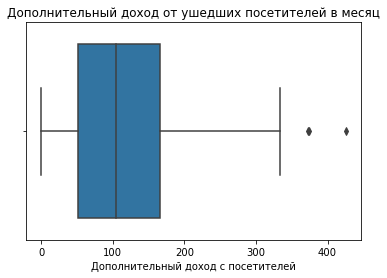

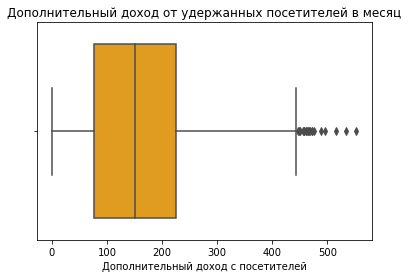

In [8]:
#Для создания гистограмм и графиков распределения создаём таблицы с данными отдельно для удержанных и для ушедших клиентов.
data_churn = data.query('churn == 1')
data_retention = data.query('churn == 0')

#Строим гисторгамму для сравнения критерия avg_additional_charges_total по обеим группам.
ax = sns.histplot(data_churn['avg_additional_charges_total'], bins = 50, color = 'blue')
sns.histplot(data_retention['avg_additional_charges_total'], bins = 50, color="orange", alpha = 0.7)
plt.title('Дополнительный доход от посетителей в месяц')
ax.set(xlabel='Дополнительный доход с посетителей', ylabel='Количество посетителей')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()

#Строим график плотности распределения критерия avg_additional_charges_total для обеих групп.
ax = sns.distplot(data_churn['avg_additional_charges_total'], bins = 50, color = 'blue')
sns.distplot(data_retention['avg_additional_charges_total'], bins = 50, color="orange")
plt.title('Дополнительный доход от посетителей в месяц')
ax.set(xlabel='Дополнительный доход с посетителей')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])

plt.show()

sns.boxplot(x = 'avg_additional_charges_total', data = data_churn)
plt.title('Дополнительный доход от ушедших посетителей в месяц')
plt.xlabel('Дополнительный доход с посетителей')
plt.show()
sns.boxplot(x = 'avg_additional_charges_total', data = data_retention, color="orange")
plt.title('Дополнительный доход от удержанных посетителей в месяц')
plt.xlabel('Дополнительный доход с посетителей')
plt.show()

Удержанные клиенты приносят больше денег, чем оттёкшие, по двум причинам. Во-первых, их ощутимо больше, во-вторых, они в среднем платят занчительно больше. Распределение в обоих случаях приближается к нормальному. Так же в обоих случаях оно скошено вправо. В обеих группах довольно много людей, не пользующихся дополнительными услугами.
Медианная прибыль фитнес-центра от удержанных посетителей составляет чуть более 150 руб. в мес., что в полтора раза больше того же показателя для ушедших.

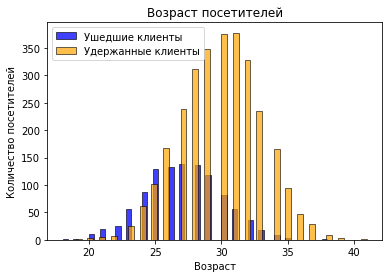

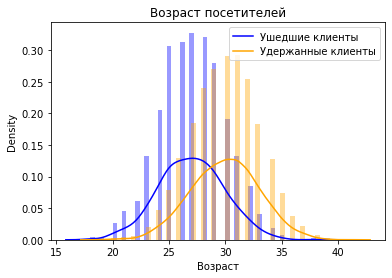

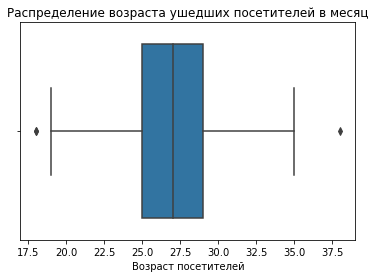

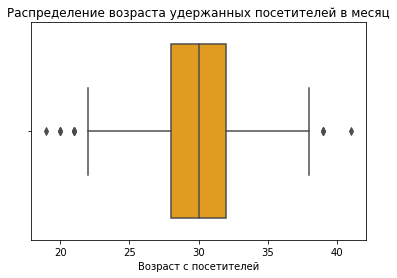

In [9]:
#Строим гисторгамму для сравнения критерия age по обеим группам.
ax = sns.histplot(data_churn['age'], bins = 50, color = 'blue')
sns.histplot(data_retention['age'], bins = 50, color="orange", alpha = 0.7)
plt.title('Возраст посетителей')
ax.set(xlabel='Возраст', ylabel='Количество посетителей')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()

#Строим график плотности распределения критерия age для обеих групп.
ax = sns.distplot(data_churn['age'], bins = 50, color = 'blue')
sns.distplot(data_retention['age'], bins = 50, color="orange")
plt.title('Возраст посетителей')
ax.set(xlabel='Возраст')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])

plt.show()

#Строим диаграммы распределения для критерия age для каждой из групп (удержанных и ушедших).
sns.boxplot(x = 'age', data = data_churn)
plt.title('Распределение возраста ушедших посетителей в месяц')
plt.xlabel('Возраст посетителей')
plt.show()
sns.boxplot(x = 'age', data = data_retention, color="orange")
plt.title('Распределение возраста удержанных посетителей в месяц')
plt.xlabel('Возраст с посетителей')
plt.show()

Возраст в обеих группах распределён практьически нормально. График распределения удержанных клиентов имеет небольшую скошенность влево.
Медианный возраст ушедших пользователей - 27 лет, удержанных - 30. Возраст основной массы посетителей первой гуппы от 19 до 35 лет. Второй - от 19 до 37.5 лет.

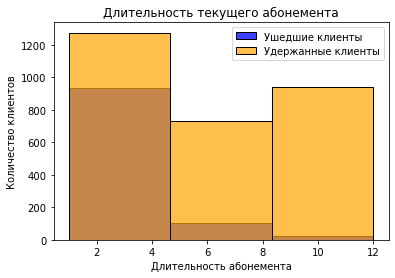

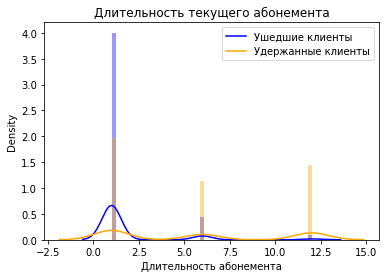

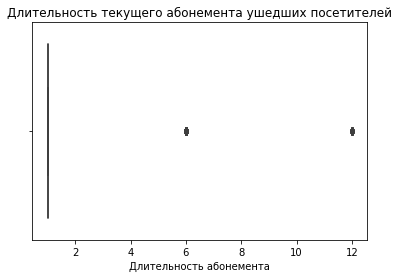

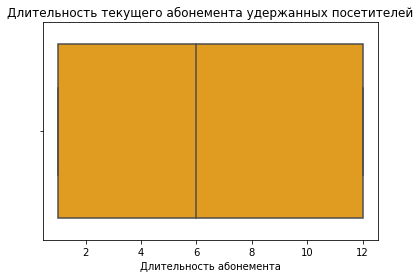

In [10]:
#Строим гисторгамму для сравнения критерия contract_period по обеим группам.
ax = sns.histplot(data_churn['contract_period'], bins = 3, color = 'blue')
sns.histplot(data_retention['contract_period'], bins = 3, color="orange", alpha = 0.7)
plt.title('Длительность текущего абонемента')
ax.set(xlabel='Длительность абонемента', ylabel='Количество клиентов')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()

#Строим график плотности распределения критерия contract_period для обеих групп.
ax = sns.distplot(data_churn['contract_period'], bins = 50, color = 'blue')
sns.distplot(data_retention['contract_period'], bins = 50, color="orange")
plt.title('Длительность текущего абонемента')
ax.set(xlabel='Длительность абонемента')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])

plt.show()

#Строим диаграммы распределения для критерия contract_period для каждой из групп (удержанных и ушедших).
sns.boxplot(x = 'contract_period', data = data_churn)
plt.title('Длительность текущего абонемента ушедших посетителей')
plt.xlabel('Длительность абонемента')
plt.show()
sns.boxplot(x = 'contract_period', data = data_retention, color="orange")
plt.title('Длительность текущего абонемента удержанных посетителей')
plt.xlabel('Длительность абонемента')
plt.show()

Большинство посетителей, как удержанных, так и "оттёкших" предпочитают приобретать месячный абонемент, как если бы не имели долгосрочных планов на тренировки. Но у "оттёкших" доля таких значительно выше. Значит, большинство прекративших занятия, прекращают их в течение первого месяца. На графике отражено мультимодальное распределение, что вызванно, вероятно, тем фактом, что на одной диаргамме/одном графике у нас представленны данные трёх разных групп (польхователей 1-, 6-, 12-месячного абонементов).
Распределение демонстрирует факт того, что ушедшие посетители практически всегда брали месячный абонемент, тогда как представители этой же группы, приобретавшие абонемент на 6 мес. или на год, составляют выброс.
Для удержанных посетителей boxplot никаких дополнительных полезных данных не даёт.

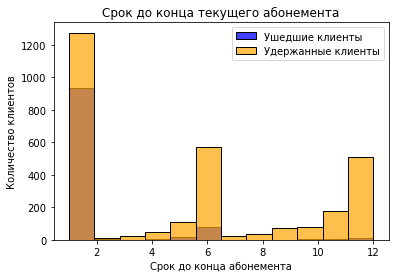

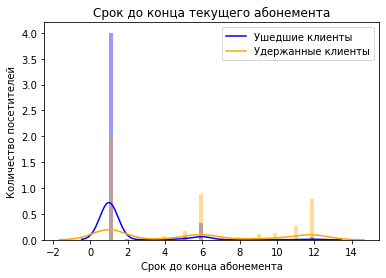

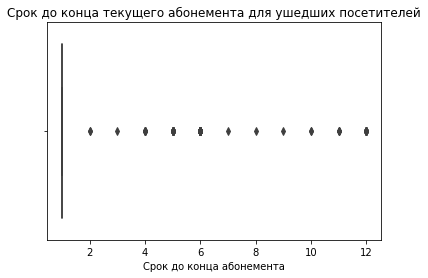

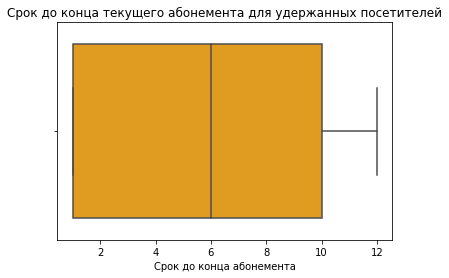

In [11]:
#Строим гисторгамму для сравнения критерия month_to_end_contract по обеим группам.

ax = sns.histplot(data_churn['month_to_end_contract'], bins = 12, color = 'blue')
sns.histplot(data_retention['month_to_end_contract'], bins = 12, color="orange", alpha = 0.7)
plt.title('Срок до конца текущего абонемента')
ax.set(xlabel='Срок до конца абонемента', ylabel='Количество клиентов')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()

#Строим график плотности распределения критерия month_to_end_contract для обеих групп.
ax = sns.distplot(data_churn['month_to_end_contract'], bins = 50, color = 'blue')
sns.distplot(data_retention['month_to_end_contract'], bins = 50, color="orange")
plt.title('Срок до конца текущего абонемента')
ax.set(xlabel='Срок до конца абонемента', ylabel='Количество посетителей')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()


#Строим диаграммы распределения для критерия month_to_end_contract для каждой из групп (удержанных и ушедших).
sns.boxplot(x = 'month_to_end_contract', data = data_churn)
plt.title('Срок до конца текущего абонемента для ушедших посетителей')
plt.xlabel('Срок до конца абонемента')
plt.show()

sns.boxplot(x = 'month_to_end_contract', data = data_retention, color="orange")
plt.title('Срок до конца текущего абонемента для удержанных посетителей')
plt.xlabel('Срок до конца абонемента')
plt.show()


У подавляющего большинства в обеих группах срок до конца действующего абонемента около одного месяца. Распределение так же полимодальное. Второй и третий пики имеют скошенность влево. Такая картина, как и в предыдущем случае обусловлена, очевидно, ем фактом, что на одной диаргамме/одном графике у нас представленны данные трёх разных групп (польхователей 1-, 6-, 12-месячного абонементов).
Как и в предыдущем случае, для ушедших пользователей любое значение больше месяца является выбросом. Медианное значение этой характеристики для удержанных пользователей - 6 мес. Срок до конца действия абонемента для большинства удержанных клиентов не превышает 10 мес.
Текущая характеристика сильно коррелирует с предыдущей.

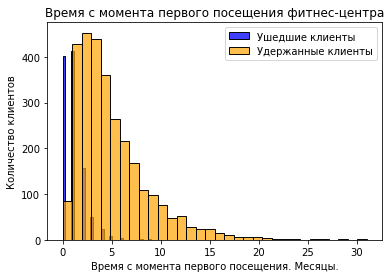

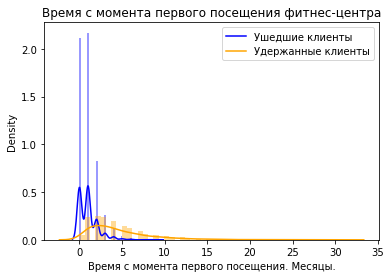

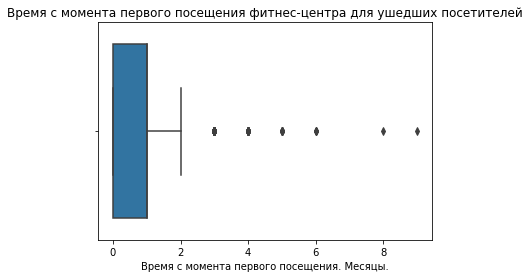

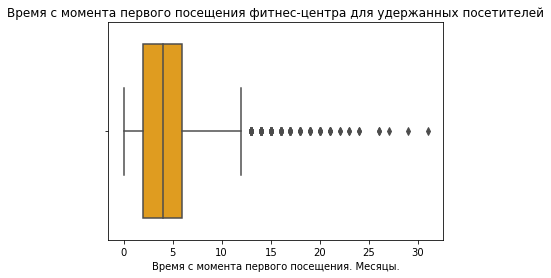

In [12]:
#Строим гисторгамму для сравнения критерия lifetime по обеим группам.
ax = sns.histplot(data_churn['lifetime'], bins = 32, color = 'blue')
sns.histplot(data_retention['lifetime'], bins = 32, color="orange", alpha = 0.7)
plt.title('Время с момента первого посещения фитнес-центра')
ax.set(xlabel='Время с момента первого посещения. Месяцы.', ylabel='Количество клиентов')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()


#Строим график плотности распределения критерия lifetime для обеих групп.
ax = sns.distplot(data_churn['lifetime'], bins = 50, color = 'blue')
sns.distplot(data_retention['lifetime'], bins = 50, color="orange")
plt.title('Время с момента первого посещения фитнес-центра')
ax.set(xlabel='Время с момента первого посещения. Месяцы.')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])

plt.show()


#Строим диаграммы распределения для критерия lifetime для каждой из групп (удержанных и ушедших).
sns.boxplot(x = 'lifetime', data = data_churn)
plt.title('Время с момента первого посещения фитнес-центра для ушедших посетителей')
plt.xlabel('Время с момента первого посещения. Месяцы.')
plt.show()
sns.boxplot(x = 'lifetime', data = data_retention, color="orange")
plt.title('Время с момента первого посещения фитнес-центра для удержанных посетителей')
plt.xlabel('Время с момента первого посещения. Месяцы.')
plt.show()

Распределение для удержанных приближается к нормальному и имеет скошенность вправо. Распределение для "оттёкших" Так же имеет скошенность в право. Кроме того оно показывает два пика. Это, очевидно, вызванно тем, что фактически у нас здесь две группы посетителей:
1. те, кто посещал фитнес-центр по крайней мере месяц;
2. те, кто практически сразу прекратил посещение или после приобретения абонемента вообще не занимался фитнесом здесь.
Диаграмма распределения демонстрирует факт того, что ушедшие посетители чаще всего с момента первого посещения ходили в фитнес-центр месяц или меньше. Основная масса людей из этой группы посещала занятия не более двух месяцев с момента первого посещения. Лайфтайм от 2-х до 9-ти мес. здесь составляет выброс.
Медианное значение лайфтайма удержанных посетителей - около 4 мес. Лайфтайм основной массы клиентов фитнес-центра - до 1 года. Всё что больше (до 31 мес.) попадает в выброс.
Удержанные пользователи обычно имеют лайфтайм в несколько раз больший, чем ушедшие.

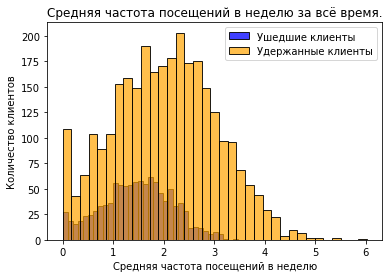

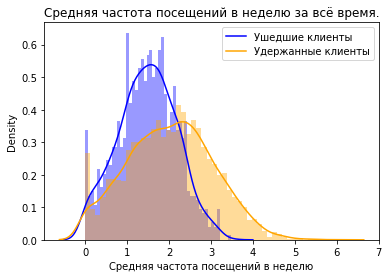

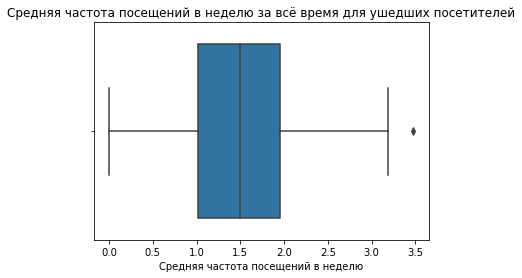

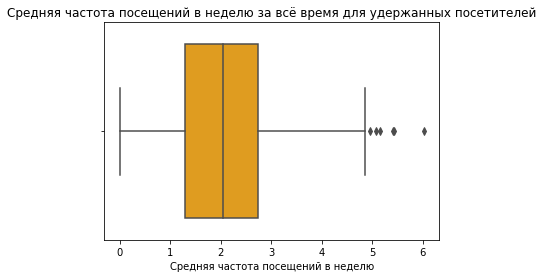

In [13]:
#Строим гисторгамму для сравнения критерия avg_class_frequency_total по обеим группам.
ax = sns.histplot(data_churn['avg_class_frequency_total'], bins = 35, color = 'blue')
sns.histplot(data_retention['avg_class_frequency_total'], bins = 35, color="orange", alpha = 0.7)
plt.title('Средняя частота посещений в неделю за всё время.')
ax.set(xlabel='Средняя частота посещений в неделю', ylabel='Количество клиентов')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()

#Строим график плотности распределения критерия avg_class_frequency_total для обеих групп.
ax = sns.distplot(data_churn['avg_class_frequency_total'], bins = 50, color = 'blue')
sns.distplot(data_retention['avg_class_frequency_total'], bins = 50, color="orange")
plt.title('Средняя частота посещений в неделю за всё время.')
ax.set(xlabel='Средняя частота посещений в неделю')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])

plt.show()

#Строим диаграммы распределения для критерия avg_class_frequency_total для каждой из групп (удержанных и ушедших).
sns.boxplot(x = 'avg_class_frequency_total', data = data_churn)
plt.title('Средняя частота посещений в неделю за всё время для ушедших посетителей')
plt.xlabel('Средняя частота посещений в неделю')
plt.show()
sns.boxplot(x = 'avg_class_frequency_total', data = data_retention, color="orange")
plt.title('Средняя частота посещений в неделю за всё время для удержанных посетителей')
plt.xlabel('Средняя частота посещений в неделю')
plt.show()

В обоих случая распределение стремится к нормальному. Распределение удержанных имеет скошенность вправо. Из этого видно, что среди них больше людей предпочитает частые (более двух раз в неделю) занятия, чем среди "оттёкших". Пик распределения ушедших клиентов - более острый, из чего следует, что большинство из них предпочитало ходить на тренировки один, максимум - два раза в неделю. То есть он, по-видимому, не были изначально настроены на систематические занятия.
Медианное значение средней частоты посещений в неделю за всё время для ушедших пользователей составляет 1.5 раза в неделю, тогда как основная масса представителей этой группы посещает фитнес-центр 3 раза в неделю и реже. Посещение больше трёх раз в неделю составляет выброс.
Медианное значение этого показателя для удержанных - 2 раза в неделю, тогда как основная масса представителей этой группы посещает фитнес-центр 4-5 раз в неделю. Всё, что больше, - попадает в выброс.

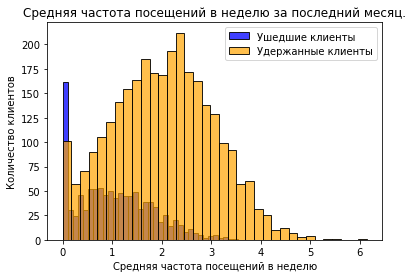

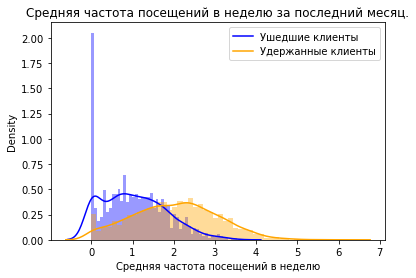

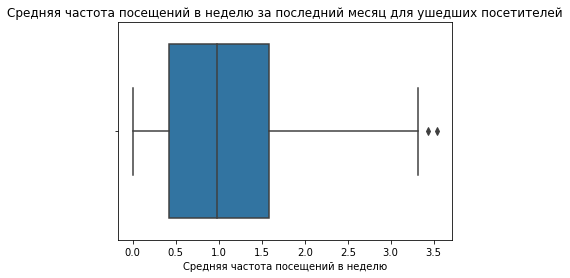

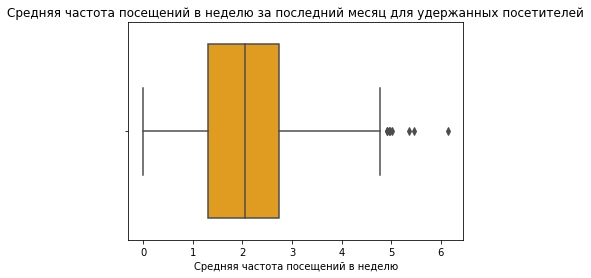

In [14]:
#Строим гисторгамму для сравнения критерия avg_class_frequency_current_month по обеим группам.
ax = sns.histplot(data_churn['avg_class_frequency_current_month'], bins = 35, color = 'blue')
sns.histplot(data_retention['avg_class_frequency_current_month'], bins = 35, color="orange", alpha = 0.7)
plt.title('Средняя частота посещений в неделю за последний месяц.')
ax.set(xlabel='Средняя частота посещений в неделю', ylabel='Количество клиентов')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()

#Строим график плотности распределения критерия avg_class_frequency_current_month для обеих групп.
ax = sns.distplot(data_churn['avg_class_frequency_current_month'], bins = 50, color = 'blue')
sns.distplot(data_retention['avg_class_frequency_current_month'], bins = 50, color="orange")
plt.title('Средняя частота посещений в неделю за последний месяц.')
ax.set(xlabel='Средняя частота посещений в неделю')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])

plt.show()

#Строим диаграммы распределения для критерия avg_class_frequency_current_month для каждой из групп (удержанных и ушедших).
sns.boxplot(x = 'avg_class_frequency_current_month', data = data_churn)
plt.title('Средняя частота посещений в неделю за последний месяц для ушедших посетителей')
plt.xlabel('Средняя частота посещений в неделю')
plt.show()

sns.boxplot(x = 'avg_class_frequency_current_month', data = data_retention, color="orange")
plt.title('Средняя частота посещений в неделю за последний месяц для удержанных посетителей')
plt.xlabel('Средняя частота посещений в неделю')
plt.show()

Распределение для удержанных посетителей практически нормальное. Распределение для "оттёкших" посетителей имеет два пика, это, очевидно, вызванно тем, что здесь фактически две категории клиентов: посещавшие фитнес-центр недолго и вообще не посещавшие.
Диаграмма распределения ушедших клиентов указывает на то, что медианная частота посещений для них - 1 раз в неделю, тогда как основная масса посетителей из этой группы посещала фитнес-центр до 3-х дней в неделю (3.25). Более частое посещение для этой группы составляет выброс.
Диаграмма распределения удержанных клиентов указывает на то, что медианная частота посещений для них - 2 раза в неделю, тогда как основная масса посетителей из этой группы посещала фитнес-центр до 5-ти дней в неделю (около 4.8). Более частое посещение для этой группы составляет выброс.
Графики распределения подтверждают предположение о том что данная характеристика имеет высокую корреляцию с предыдущей.

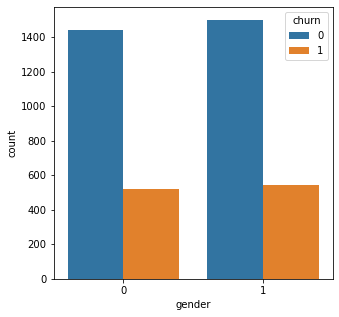

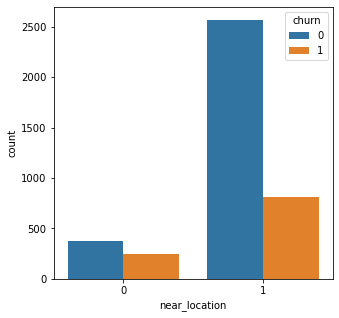

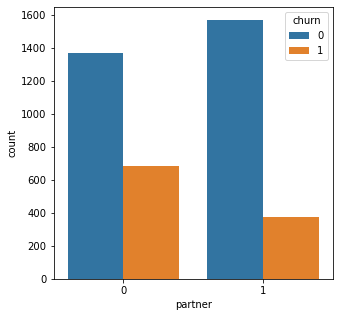

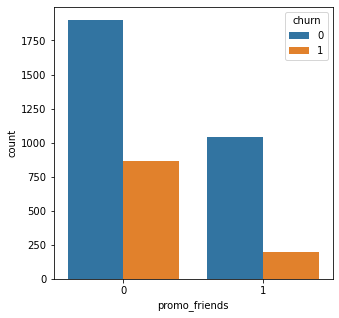

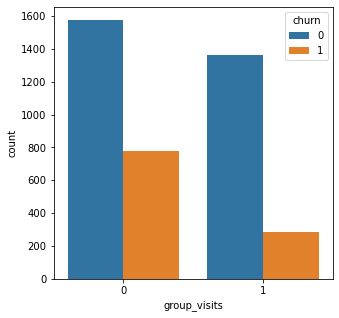

In [15]:
#Строим столбчатые диаграммы для бинарных признаков
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = data[column], hue='churn', data=data)
    plt.show()

В соотношении полов разницы в соотношении удержанных и ушедших почти нет.

Среди тех, кто живёт или работает недалеко от фитнес-центра, доля оттока заметно ниже, чем среди тех, кто находится обычно далеко от него.

Среди участников партнёрской программы доля оттока в два раза ниже.

По акции "приведи друга" приходит около трети клиентов, но доля оттока среди них почти в два раза ниже.

Групповые занятия несколько менее популярны, чем индивидуальные, однако доля оттока на групповых занятиях ниже в четыре раза.

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


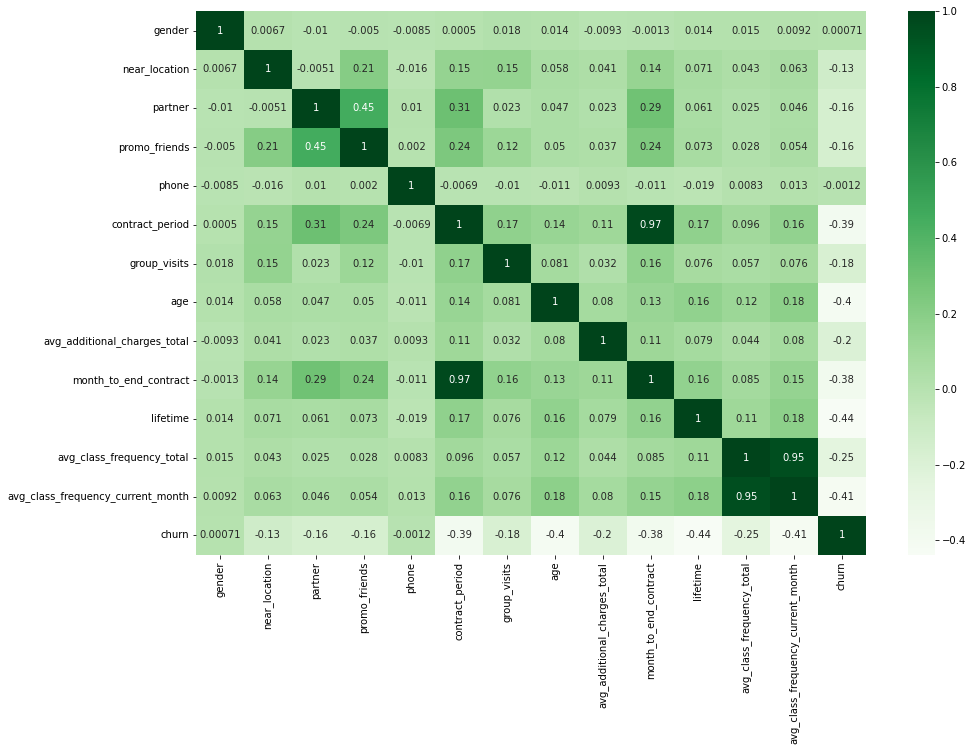

In [16]:
data2 = data.corr()
display(data2)
plt.figure(figsize=(15,10))
sns.heatmap(data2, annot=True, cmap="Greens")
plt.show()

Матрица корреляции подтверждает промежуточный вывод о высоком уровне корреляции двух пар характеристик.
Первая пара - avg_class_frequency_current_month и avg_class_frequency_total. Вторая пара - contract_period и month_to_end_contract. Поскольку в рамках поставленной задачи нам необходимо применить логистическую регрессию, случайный лес и кластеризацию, ничего делать с коррелирующими признаками не нужно. Из других критериев ощутимо на удержание и отток влияют partner и promo_friends. Люди, участвующие в этих программах реже уходят в отток.

## Создание модели прогнозирования оттока клиентов.<a id="model_creation"></a>

In [17]:
#делим данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns = ['churn'])
y = data['churn']

# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)


# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# обучаем модель логистической регрессии
model_log_regression = LogisticRegression(solver='liblinear', random_state = 0)
model_log_regression.fit(X_train_st, y_train)

# прогнозируем отток клиентов
log_reg_predictions = model_log_regression.predict(X_test_st)
# прогнозируем вероятность ухода клиентов в отток
log_reg_probabilities = model_log_regression.predict_proba(X_test_st)[:, 1]

display(log_reg_predictions)
display(log_reg_probabilities)

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

array([9.06909055e-01, 3.83321916e-02, 7.24947446e-03, 2.40480387e-02,
       1.24804769e-02, 1.66033239e-03, 2.94778836e-05, 6.39035750e-02,
       9.97200599e-01, 9.17959778e-03, 6.07275378e-04, 3.23305056e-01,
       1.96395243e-03, 9.81550673e-01, 8.21861861e-01, 1.28016346e-02,
       6.58613708e-02, 2.42665624e-01, 3.02734265e-01, 1.59776100e-04,
       2.54639766e-01, 8.31951601e-01, 2.66688839e-01, 1.98282581e-03,
       9.87275917e-01, 2.27812593e-01, 5.25554005e-01, 1.42881404e-05,
       4.80172057e-03, 2.90711452e-03, 3.89225022e-01, 9.83381190e-04,
       2.52453691e-04, 5.35777709e-01, 1.33019924e-02, 2.90876607e-02,
       1.19815713e-02, 2.19386443e-05, 4.12017454e-03, 6.04575733e-04,
       9.99112500e-06, 1.14747513e-02, 2.12401053e-05, 9.97323663e-01,
       2.45558522e-05, 9.64196389e-07, 1.62606901e-02, 9.20845542e-01,
       2.69628671e-03, 8.36520254e-03, 2.11633940e-01, 5.12127415e-01,
       9.57571478e-03, 1.24042936e-02, 9.41461597e-01, 1.15185376e-03,
      

In [18]:
#Выводим метрики логистической регрессии
display('Метрики логистической регрессии:')
display('Accuracy: {:.2f}'.format(accuracy_score(y_test, log_reg_predictions)))
display('Precision: {:.2f}'.format(precision_score(y_test, log_reg_predictions)))
display('Recall: {:.2f}'.format(recall_score(y_test, log_reg_predictions)))

'Метрики логистической регрессии:'

'Accuracy: 0.94'

'Precision: 0.90'

'Recall: 0.85'

In [19]:
#обучаем модель случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)

# прогнозируем отток клиентов
rf_predictions = rf_model.predict(X_test_st)
# прогнозируем вероятность ухода клиентов в отток
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]


display(rf_predictions)
display(rf_probabilities)

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,

array([0.95, 0.13, 0.02, 0.02, 0.06, 0.03, 0.01, 0.26, 0.92, 0.01, 0.01,
       0.33, 0.  , 0.92, 0.62, 0.11, 0.2 , 0.34, 0.38, 0.01, 0.07, 0.77,
       0.26, 0.  , 0.85, 0.27, 0.3 , 0.03, 0.07, 0.  , 0.56, 0.04, 0.05,
       0.51, 0.22, 0.05, 0.09, 0.19, 0.  , 0.01, 0.  , 0.05, 0.01, 0.97,
       0.  , 0.  , 0.07, 0.87, 0.  , 0.  , 0.14, 0.43, 0.01, 0.01, 0.87,
       0.05, 0.04, 0.  , 0.19, 0.01, 0.98, 0.04, 0.  , 0.01, 0.98, 0.07,
       0.06, 0.16, 0.31, 0.29, 0.14, 0.  , 0.78, 0.2 , 0.18, 0.07, 0.93,
       0.  , 0.  , 0.11, 0.  , 0.12, 0.03, 0.97, 0.03, 0.02, 0.07, 0.76,
       0.02, 0.69, 0.88, 0.01, 0.04, 0.11, 0.9 , 0.01, 0.14, 0.47, 0.95,
       0.02, 0.02, 0.  , 0.01, 0.02, 0.  , 0.57, 0.  , 0.99, 0.11, 0.03,
       0.04, 0.63, 0.05, 0.13, 0.03, 0.  , 0.07, 0.18, 0.08, 0.  , 0.  ,
       0.18, 0.86, 0.99, 0.58, 0.15, 0.46, 0.02, 0.04, 0.32, 0.  , 0.46,
       0.08, 0.07, 0.06, 0.02, 0.04, 0.6 , 0.18, 0.87, 0.1 , 0.05, 0.11,
       0.  , 0.92, 0.11, 0.99, 0.  , 0.06, 0.64, 0.

In [20]:
#Выводим метрики случайного леса
display('Метрики случайного леса')
display('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
display('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
display('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

'Метрики случайного леса'

'Accuracy: 0.92'

'Precision: 0.88'

'Recall: 0.83'

Модель логистической регрессии несколько точнее. Она даёт немного лучшие результаты по метрикам Precision и Recall. Доля правильных ответов среди целевого класса ("churn") здесь выше и реальных посетителей, ушедших в отток она позволяет обнарудить немного больше. Доля правильных ответов в обоих случаях одинаковая.

## Кластеризация клиентов.<a id="clusters"></a>

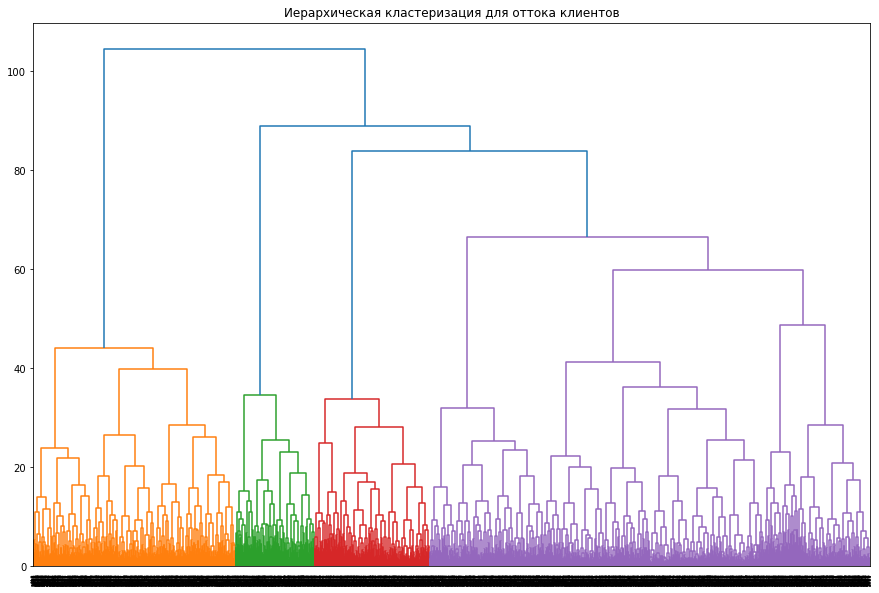

In [21]:
#Обучение Scaler и стандартизация.
sc = StandardScaler()
x_sc = sc.fit_transform(data.drop(columns = ['churn']))
#строим матрицу расстояний.
linked = linkage(x_sc, method = 'ward')
#display(x_sc[: 10])
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для оттока клиентов')
plt.show()

In [22]:
#обучаем модель кластеризации на основании алгоритма K-Means и прогнозируем кластеры клиентов
km = KMeans(n_clusters = 5, random_state = 0)
clusters = km.fit_predict(x_sc)
# сохраняем метки кластера в поле таблицы
data['clusters_km'] = clusters
churn = data[['churn', 'clusters_km']]
#считаем средние значения признаков для кластеров

data_group = data.drop(columns = 'churn').groupby('clusters_km').mean().round(2).reset_index(inplace = False)

display(data_group)

,clusters_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.50,0.96,0.78,0.57,1.0,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97
1,1,0.52,0.86,0.47,0.31,0.0,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72
2,2,0.50,0.00,0.46,0.08,1.0,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48
3,3,0.49,1.00,0.35,0.24,1.0,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01
4,4,0.56,0.98,0.36,0.23,1.0,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85


Дендрограмма наводит на мысль о четырёх или шести кластерах. однако в задании рекомендовано пять, для универсальности. Делаю как в задании, но при необходимости готов переделать.

В таблице средних значений в первую очередь видны некоторые отличия по полу посетителей. В кластере с индексом 4 (то есть, - в 5-м) эти отличия наиболее заметны. Но в данной ситуации мы ничего не можем сделать, так как нам неизвестно, какой именно пол скрывается за цифрами 0 или 1. Здесь ограничимся констатацией факта.
Для кластеров с индексами 0 и 4 характерны одни из самых высоких или самые высокие значения характеристик near_location, group_visits, age, avg_additional_charges_total, lifetime, avg_class_frequency_total, avg_class_frequency_current_month. Кроме того кластер с индексом 0 имеет самые высокие значения критериев partner и promo_friends, contract_period.
Для кластера с индексом 1 характерны высокие или относительно высокие значения характеристик near_location, partner, contract_period, group_visits, avg_additional_charges_total, lifetime, avg_class_frequency_total, avg_class_frequency_current_month.
Кроме того, кластеры с индексами 0, 1, 4 имеют наиболее высокие показатели среднего возраста клиентов.
Самые низкие показатели по всем характеристикам, кроме near_location и promo_friends, имеет кластер с индексом 3.

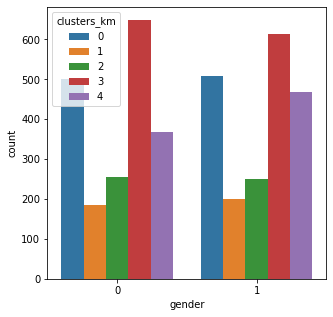

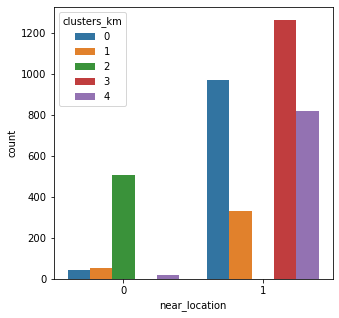

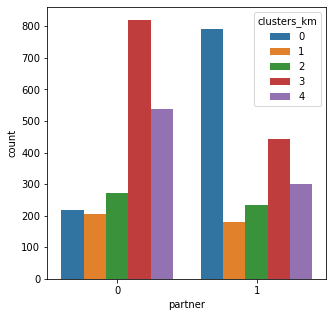

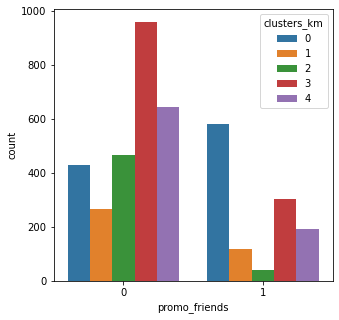

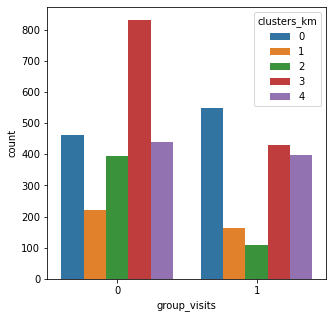

In [23]:
#строим графики для бинарных признаков
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = data[column], hue='clusters_km', data=data)
    plt.show()

Доля представителей полов по кластерам почти равна. Более или менее заметные отличия есть в кластерах с индексами 3 и, в большей степени, 4.

В кластере с индексом 2 большинство клиентов живут и работают далеко от фитнес-центра. В остальных кластерах основная их масса находятся недалеко от места занятий.

В кластерах с индексами 1 и 2 доля участвующих и не участвующих в пргамме почти равна (в первом случае участвующих чуть меньше, чем не участвующих, во втром - наоборот). В кластере с индексом 0 участвующих в партнёрской программе в 4 раза больше чем не участвующих. В остальных двух кластерах не участвующих почти в 2 раза больше.

В кластере с индексом 0 большинство участники акции "приведи друга" численно превосходят остальных почти в 1.5 раза. В остальных случаях участников акции в 2-9 раз меньше, чем тех, кто не участвовал.

Картина схожа с предыдущими двумя критериями. Клиенты, относящиеся к кластеру с индексом 0 чаще ходят на групповые занятия. Клиенты, относящиеся к кластеру с индексом 4 разделились в этом вопросе почти пополам. На групповые занятия ходит чуть меньше половины. В остальных трёх кластерах участников групповых занятий значительно меньше.

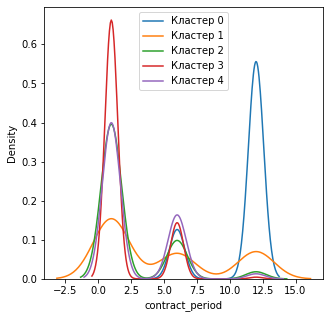

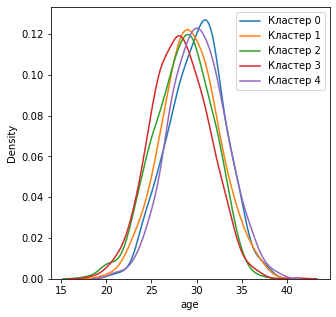

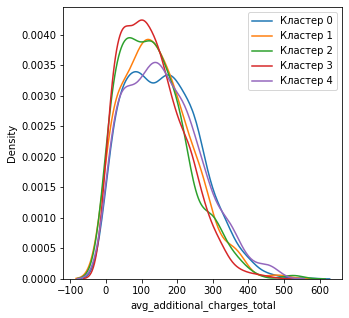

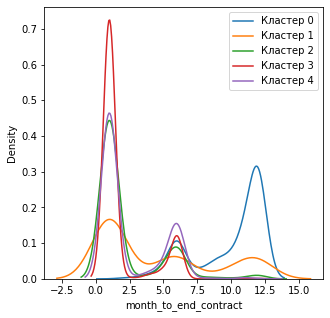

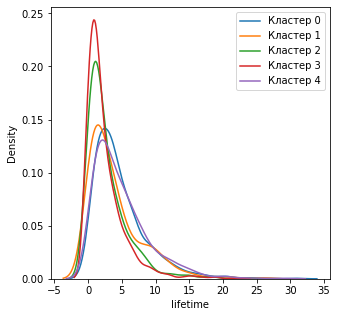

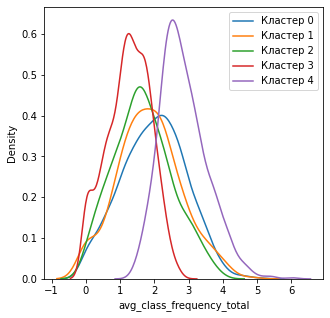

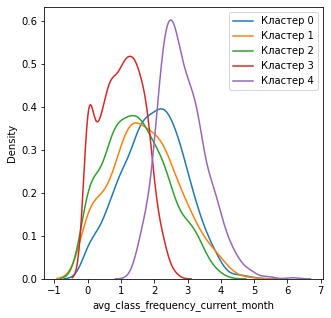

In [24]:
#Строим графики для небинарных признаков
for column in ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize=(5, 5))
    sns.kdeplot(data.query('clusters_km == 0')[column], label = 'Кластер 0')
    sns.kdeplot(data.query('clusters_km == 1')[column], label = 'Кластер 1')
    sns.kdeplot(data.query('clusters_km == 2')[column], label = 'Кластер 2')
    sns.kdeplot(data.query('clusters_km == 3')[column], label = 'Кластер 3')
    sns.kdeplot(data.query('clusters_km == 4')[column], label = 'Кластер 4')
    plt.legend()
    plt.show()

Клиенты из кластера с индексом 0 предпочитают в массе годовой абонемент. Клиенты из кластеров с индексами 1, 2, 3, 4 предпочитают абонементы на месяц.

Распределение по возрасту подтверждает данные таблицы со средними значениями характеристик. Клиенты из кластера с индексом 0 обычно старше остальных, затем идут клиенты кластера с индексом 4. Самые молодые в среднем клиенты кластера с индексом 3.

Клиенты из кластера с индексом 0 в массе своей тратят на дополнительные услуги от 50 до 200 рублей в месяц. Достаточно большое их количество тратит до 300 рублей в месяц. Похожие показатели у посетителей из кластера с индексом 4. Мееньше всех тратят клиенты из кластера с индексами 2 и 3.

Самые большие сроки до конца абонемента у посетителей из кластера с индексом 0. Они в основном имеют срок около года. У клиентов из кластера с индексом 4 основная масса имеет срок до окончания абонемента 1 месяц и самое большое в сравнении с клиентами из других кластеров количество абонементов со сроком полгода до окончания. Срок в 1 месяц чаще всего свойствен посетителям из из кластера с индексом 3.

Самый большой лайфтайм свойствен клиентам из кластера с индексом 0. От 2.2-3 месяцев до 31 месяца. Ему близок по этой характеристике кластер с индексом 4. Самый маленький лайфтайм характерен для клиентов из кластеров с индексом 2 и, в ещё большей степени, 3.

Наиболее высокая частота посещений в неделю за всё время характерна для большого количества клиентов из кластеров с индексом 0 (2 раза) и 4 (3 раза). Наименьшее количество раз в неделю фитнес-центр посещают клиенты  из из кластеров с индексом 2 и 3 (чаще всего - 1 раз в неделю).

Наиболее высокая частота посещений в неделю за последний месяц так же характерна для большого количества клиентов из кластеров с индексом 0 (около 3 раз) и 4 (3 раза). Наименьшее количество раз в неделю фитнес-центр посещают клиенты  из из кластеров с индексом 1, 2 и 3 (чаще всего - 1 раз в неделю).


In [25]:
#Выводим значения оттока для каждого из пяти кластеров
display(churn.groupby('clusters_km').mean().round(2).reset_index(inplace = False))

,clusters_km,churn
0,0,0.03
1,1,0.27
2,2,0.44
3,3,0.51
4,4,0.07


Наиболее надёжные кластеры - с индексами 0 и 4. Наиболее склонные к оттоку кластеры с индексами 3 и 2.

## Выводы и рекомендации.<a id="outcome"></a>

Выводы.
1. Для прогноза оттока лучше использовать логистическую регрессию, хотя она неприципиально точнее модели случайного леса: 'Accuracy: 0.94',
'Precision: 0.90',
'Recall: 0.85'.
2. Наиболее надёжными оказались кластеры с индексами 0 и 4. Но кластер с индексом 4 не всегда показывал высокие показатели. По ряду параметров они весьма низкие. Следовательно, необходимо обратить внимание на те параметры, которые имеют высокие значения у обоих кластеров. Сюда можно отнести удалённость от фитнес-центра. С некоторыми оговорками - возраст. И наконец, - групповые занятия. Участие в партнёрской программе и в акции "приведи друга" не особенно выраженно в кластере с индексом 4. Здесь он уступает кластеру с индексом 3, у которого самый большой показатель оттока клиентов (0.51). В то же время, обе этих характеристики характерны для посетителей из кластера с индексом 0.
3. Идеальный клиент выглядит как человек в возрасте 30-31 года. Он/она живёт и/или работает недалеко от фитнесс-центра. Он свободно/относительно свободно распоряжается своим доходом.

Рекомендации.
1. Вероятно стоит усилить привлечение более взрослых клиентов (устойчивые кластеры имеют более высокий показатель среднего возраста). Они могут быть более мотивированы в вопросах заботы о здоровье и у них в среднем больше возможностей тратить деньги на дополнительные услуги (их материальное положение лучше и стабильнее, чем у более молодых, чья карьера только начинается).
2. Абсолютно точно нужно продвигать участие клиентов в групповых занятиях (имеющиеся у нас данные как минимум не противоречат психологии - занимаясь в коллективе люди пытаются "не отставать").
3. Нужно уделить особое внимание партнёрской программе и акции "приведи друга", чтобы понять, почему участие в ней не влияет на результаты кластера с индексом 3, а так же почему устойчивый кластер с индексом 4 показывает небольшие значения по этим двум характеристикам.